# 載入函式庫 & 掛載雲端硬碟

In [ ]:
import os
from google.colab import drive

import copy
import numpy
import numpy as np
import pandas as pd
import librosa

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, LayerNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier

import scipy.io.wavfile
from scipy.fftpack import dct

drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/Colab Notebooks/Voice-Diease/')

Mounted at /content/drive


## 載入訓練資料

In [ ]:
# 讀取訓練資料集表單
source_df = pd.read_csv('./data/training_datalist.csv')

print("source_df.shape :", source_df.shape)

source_df.shape : (1000, 28)


## 切分訓練與驗證資料

In [ ]:
class_weight = {0: 1.,
          1: 2.436,
          2: 3.19,
          3: 12.182,
          4: 16.75,}

In [ ]:
training_df, validate_df = train_test_split(source_df, test_size=0.15, random_state=333)

print("training_df shape :", training_df.shape, ", test_df shape :", validate_df.shape)

training_df shape : (850, 28) , test_df shape : (150, 28)


# 資料前處理

## 聲學音檔轉換MFCC特徵

In [ ]:
def MFCCs(filename):
  # setup
  sample_rate, raw_signal = scipy.io.wavfile.read(filename) # File assumed to be in the same directory
  signal = np.zeros(int(1*44100)) #fix audio to 3.5 seconds
  if(len(raw_signal) <= len(signal)):
    signal[:len(raw_signal)] = raw_signal
  else:
    signal = raw_signal[:len(signal)]


  #pre-emphasis
  # pre_emphasis = 0.97
  # emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
  emphasized_signal = signal

  #framing
  frame_size = 0.025
  frame_stride = 0.01

  frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
  signal_length = len(emphasized_signal)
  frame_length = int(round(frame_length))
  frame_step = int(round(frame_step))
  num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

  pad_signal_length = num_frames * frame_step + frame_length
  z = numpy.zeros((pad_signal_length - signal_length))
  pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

  indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
  frames = pad_signal[indices.astype(numpy.int32, copy=False)]

  #window
  frames *= numpy.hamming(frame_length)
  # frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

  #Fourier-Transform and Power Spectrum
  NFFT = 512
  mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
  pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

  #Filter Banks
  nfilt =40
  low_freq_mel = 0
  high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
  mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
  hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
  bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

  fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
  for m in range(1, nfilt + 1):
      f_m_minus = int(bin[m - 1])   # left
      f_m = int(bin[m])             # center
      f_m_plus = int(bin[m + 1])    # right

      for k in range(f_m_minus, f_m):
          fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
      for k in range(f_m, f_m_plus):
          fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
  filter_banks = numpy.dot(pow_frames, fbank.T)
  filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
  filter_banks = 20 * numpy.log10(filter_banks)  # dB
  filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)

  return filter_banks

In [ ]:
def audioData_preprocessing(input_df, file_path):
  id_list = input_df.ID.tolist()
  data_size = input_df.shape[0]
  audio_feature = []
  for i in range(0, data_size):
    audio_feature.append(MFCCs(file_path + "{}.wav".format(id_list[i])))
  
  return np.array(audio_feature)

## 文字資料前處理

In [ ]:
def medical_data_proccessing(input_df):
    df = copy.deepcopy(input_df)
    # 將性別編碼0,1
    df['Sex'] = df['Sex'] - 1

    # 將空值填0
    df['PPD'] = df['PPD'].fillna(0)
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'].fillna(0)

    # 正規化過大的數值
    #problem : use training data to normalize 
    df['Age'] = df['Age'] / 100
    df['Voice handicap index - 10'] = df['Voice handicap index - 10'] / 40
    df['Occupational vocal demand'] /= 4
    df['Diurnal pattern'] /= 4
    df['Noise at work'] /= 3
    df['Onset of dysphonia '] /= 5
    df['frequency'] /= 3
    df['Drinking'] /= 2
    df['Smoking'] /= 3
    ## PPD just temp divided by 3
    df['PPD'] /= 3

    return df

# Fusion

In [ ]:
x_train_text = medical_data_proccessing(training_df).drop(['Disease category','ID'], axis=1).to_numpy()
x_val_text = medical_data_proccessing(validate_df).drop(['Disease category','ID'], axis=1).to_numpy()

x_train_audio = audioData_preprocessing(training_df, file_path = "./data/training_data/")
x_val_audio = audioData_preprocessing(validate_df, file_path = "./data/training_data/")

y_train = pd.get_dummies(training_df, columns=['Disease category']).to_numpy()[:,-5:].astype('float32')
y_val = pd.get_dummies(validate_df, columns=['Disease category']).to_numpy()[:,-5:].astype('float32')

print(x_train_text.shape, x_train_audio.shape, y_train.shape)
print(x_val_text.shape, x_val_audio.shape, y_val.shape)

(850, 26) (850, 98, 40) (850, 5)
(150, 26) (150, 98, 40) (150, 5)


In [ ]:
x_train = np.concatenate((x_train_text, x_train_audio.reshape(850,-1)), axis = 1)
x_val = np.concatenate((x_val_text, x_val_audio.reshape(150,-1)), axis = 1)

##Traditional Model

In [ ]:
y_true = validate_df['Disease category'] - 1

In [ ]:
mnb = GaussianNB()
clf = mnb.fit(x_train, np.argmax(y_train, axis=1))
y_pred = clf.predict(x_val)

print(((clf.predict(x_train)) == np.argmax(y_train, axis=1)).sum() / len(y_train))
print((clf.predict(x_val) == np.argmax(y_val, axis=1)).sum() / len(y_val))


results_recall = recall_score(y_true, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())

In [ ]:
clf = LogisticRegression(class_weight=class_weight, max_iter=5000)
clf = clf.fit(x_train, np.argmax(y_train, axis=1))
y_pred = clf.predict(x_val)

print(( clf.predict(x_train) == np.argmax(y_train, axis=1)).sum() / len(y_train))
print((clf.predict(x_val) == np.argmax(y_val, axis=1)).sum() / len(y_val))

results_recall = recall_score(y_true, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())

In [ ]:
clf = SGDClassifier(loss='hinge')
clf = clf.fit(x_train, np.argmax(y_train, axis=1))
y_pred = clf.predict(x_val)

print(( clf.predict(x_train) == np.argmax(y_train, axis=1)).sum() / len(y_train))
print((clf.predict(x_val) == np.argmax(y_val, axis=1)).sum() / len(y_val))

results_recall = recall_score(y_true, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())

0.3058823529411765
0.22
Test UAR(Unweighted Average Recall) : 0.22497184125091102


In [ ]:
np.random.seed(42)
X = x_train
y = np.array(training_df['Disease category'] - 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_classifier = SVC(kernel="sigmoid", C=1, gamma="auto", random_state=42, probability=True, decision_function_shape='ovr')
svm_classifier.fit(X_train_scaled, y_train)
y_pred = svm_classifier.predict(X_test_scaled)

results_recall = recall_score(y_test, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())

Test UAR(Unweighted Average Recall) : 0.2674221724524076


## Model

In [ ]:
def create_mutiModel(input_shape, neurons = 600, hidden_layers = 5, learning_rate = 0.001, verbose=0):
    model = Sequential()

    model.add(Dense(neurons, input_dim=input_shape))
    model.add(Activation('relu'))
    model.add(layers.Dropout(0.1))
    #model.add(BatchNormalization())
    model.add(LayerNormalization())

    for i in range(hidden_layers-1):
        model.add(Dense(neurons))
        model.add(Activation('relu'))
        model.add(layers.Dropout(0.1))
        model.add(BatchNormalization())
        #model.add(LayerNormalization())

    model.add(Dense(5))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) # categorical_crossentropy

    if verbose:
        model.summary()
    
    return model

multi_model = create_mutiModel(input_shape = x_train.shape[1])
print(x_train.shape)

(850, 3946)


## 訓練

In [ ]:
train_history = multi_model.fit(x_train, y_train, batch_size=256, epochs=10000, class_weight = class_weight, 
                  callbacks=[ModelCheckpoint("multi_model_600*50_0.001.h5", save_best_only=True, monitor='val_accuracy')], 
                  validation_data=(x_val, y_val)
                  )


score = multi_model.evaluate(x_val, y_val, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10000
4/4 [==============================] - 4s 226ms/step - loss: 3.1940e-05 - accuracy: 1.0000 - val_loss: 6.9076 - val_accuracy: 0.4600
Epoch 2/10000
4/4 [==============================] - 0s 29ms/step - loss: 0.0019 - accuracy: 0.9988 - val_loss: 7.0473 - val_accuracy: 0.4333
Epoch 3/10000
4/4 [==============================] - 0s 29ms/step - loss: 0.0037 - accuracy: 0.9976 - val_loss: 7.1088 - val_accuracy: 0.4200
Epoch 4/10000
4/4 [==============================] - 0s 32ms/step - loss: 0.0014 - accuracy: 0.9988 - val_loss: 7.1071 - val_accuracy: 0.4267
Epoch 5/10000
4/4 [==============================] - 0s 26ms/step - loss: 0.0105 - accuracy: 0.9988 - val_loss: 7.0305 - val_accuracy: 0.4467
Epoch 6/10000
4/4 [==============================] - 0s 29ms/step - loss: 0.0124 - accuracy: 0.9988 - val_loss: 6.7446 - val_accuracy: 0.4533
Epoch 7/10000
4/4 [==============================] - 0s 32ms/step - loss: 7.3747e-05 - accuracy: 1.0000 - val_loss: 6.6157 - val_accuracy: 0.44

KeyboardInterrupt: ignored

## 結果

In [ ]:
multi_model = load_model("multi_model_600*50_0.001.h5")
y_pred = multi_model.predict(x_train).argmax(axis=1)
y_true = training_df['Disease category'] - 1

results_recall = recall_score(y_true, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())

27/27 [==============================] - 0s 2ms/step
Test UAR(Unweighted Average Recall) : 1.0


5/5 [==============================] - 0s 3ms/step
Test UAR(Unweighted Average Recall) : 0.3548267408732525


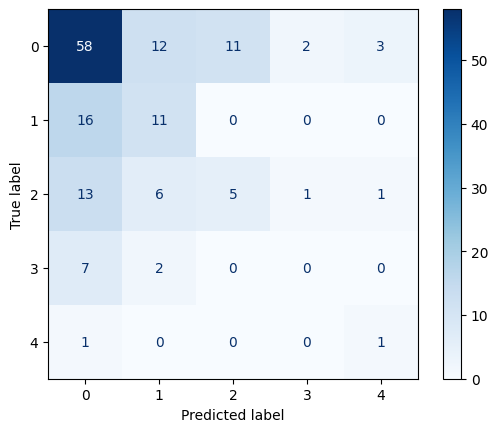

In [ ]:
y_pred = multi_model.predict(x_val).argmax(axis=1)
# y_pred = (text_model.predict(x_val_text) + audio_model.predict(x_val_audio)).argmax(axis=1)
# y_pred = (np.eye(5)[clf.predict(x_val_text)] + audio_model.predict(x_val_audio)).argmax(axis=1)
y_true = validate_df['Disease category'] - 1

results_recall = recall_score(y_true, y_pred, average=None)
print("Test UAR(Unweighted Average Recall) :", results_recall.mean())
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')